# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.matrix_utils import compute_q_pi, preprocess_passing_matrix
from scripts.data_processing import process_team_games, rolling_average
from scripts.estimation import pi_mle

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Single Passing Matrix Example

This illustrates calculation of performance metrics for a single passing matrix (specifically, for Arsenal's first game in the 2018--2019 season).

In [2]:
# Read the passing matrix and initial possession data
P_df = pd.read_csv('data/passing_matrix/EPL2018-2019/Arsenal_passing_matrix_2018-08-12.csv')
alpha_df = pd.read_csv('data/passing_matrix/EPL2018-2019/Arsenal_initial_possession_2018-08-12.csv')

In [3]:
# View the raw passing matrix
P_df

,Unnamed: 0,Denis Suárez,Mesut Özil,Emile Smith Rowe,Granit Xhaka,Mohamed Elneny,Alex Iwobi,Konstantinos Mavropanos,Sokratis Papastathopoulos,Zech Medley,...,Laurent Koscielny,Sead Kolasinac,Bernd Leno,Lucas Torreira,Rob Holding,Danny Welbeck,Nacho Monreal,Successful,Unsuccessful,Unsuccessful Pass
0,Denis Suárez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mesut Özil,0,0,0,4,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11
2,Emile Smith Rowe,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Granit Xhaka,0,7,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,9
4,Mohamed Elneny,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Alex Iwobi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Konstantinos Mavropanos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Sokratis Papastathopoulos,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
8,Zech Medley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Emiliano Martínez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Convert dataframe to numpy array by dropqng first column and selecting only numeric columns
P_raw = P_df.iloc[:, 1:].to_numpy()

# Preprocess the passing matrix
P = preprocess_passing_matrix(P_raw)

Here, $P$ is the passing matrix converted into a probability transition matrix.

In [5]:
# without headers
print(P)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.2972973]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 0.        0.        1.       ]]


In [6]:

# formatted
# Create headers list from P_df columns, excluding first and replacing last 3 with S, U
headers = list(P_df.columns[1:-3]) + ['S', 'U']

# Convert P to DataFrame with headers
P_formatted = pd.DataFrame(P, columns=headers, index=headers)

# Look at first FOUR columns and last two columns (S and U)
P_formatted.iloc[:, [0, 1, 2, 3, -2, -1]]


,Denis Suárez,Mesut Özil,Emile Smith Rowe,Granit Xhaka,S,U
Denis Suárez,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mesut Özil,0.0000,0.0000,0.0000,0.1081,0.0000,0.2973
Emile Smith Rowe,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Granit Xhaka,0.0000,0.1628,0.0000,0.0000,0.0000,0.2093
Mohamed Elneny,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Alex Iwobi,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Konstantinos Mavropanos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Sokratis Papastathopoulos,0.0000,0.0000,0.0000,0.1351,0.0000,0.1892
Zech Medley,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Emiliano Martínez,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [7]:
# Another example usage
P_formatted.loc[['Granit Xhaka', 'Alexandre Lacazette', 'Henrikh Mkhitaryan'], 
                ['Granit Xhaka', 'Alexandre Lacazette', 'Henrikh Mkhitaryan', 'S', 'U']]

,Granit Xhaka,Alexandre Lacazette,Henrikh Mkhitaryan,S,U
Granit Xhaka,0.0000,0.0465,0.0698,0.0000,0.2093
Alexandre Lacazette,0.0000,0.0000,0.1071,0.0357,0.3214
Henrikh Mkhitaryan,0.0619,0.0619,0.0000,0.0103,0.2474


Compute $q$ and $\pi$ using $P$ and $\alpha$.

In [8]:
# remove last three rows corresponding to successful shot, unsuccessful shot, and unsuccessful pass
alpha = alpha_df.iloc[:-3, 1].to_numpy()

q, pi = compute_q_pi(P, alpha)

Here are the top 10 $\pi$ (and $q$) values for the game:

In [9]:
game_1_df = pd.DataFrame({'q': q, 'pi': pi})
game_1_df.index = P_df.columns[1:-3]
game_1_df.sort_values('pi', ascending=False, inplace=True)
game_1_df.head(10)

,q,pi
Henrikh Mkhitaryan,0.4026,0.1117
Mattéo Guendouzi,0.3777,0.1048
Alexandre Lacazette,0.3478,0.0965
Shkodran Mustafi,0.3229,0.0896
Héctor Bellerín,0.2962,0.0822
Granit Xhaka,0.2734,0.0758
Pierre-Emerick Aubameyang,0.2612,0.0724
Mesut Özil,0.2486,0.0690
Stephan Lichtsteiner,0.2174,0.0603
Petr Cech,0.2116,0.0587


# Over Multiple Games within a Season

In [10]:
# Example usage
folder = "EPL2018-2019"
team = "Arsenal"
q_df, pi_df = process_team_games(folder, team, max_games=38)

In [11]:

pi_df


,2018-08-12,2018-08-18,2018-08-25,2018-09-02,2018-09-15,2018-09-23,2018-09-29,2018-10-07,2018-10-22,2018-10-28,...,2019-03-02,2019-03-10,2019-04-01,2019-04-07,2019-04-15,2019-04-21,2019-04-24,2019-04-28,2019-05-05,2019-05-12
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Ramsey,0.0453,0.0347,0.1001,0.0972,0.0735,0.0730,0.0430,0.0956,0.0278,0.0107,...,0.1674,0.1051,0.1294,0.1565,0.1039,0.0000,0.0000,0.0000,0.0000,0.0000
Ainsley Maitland-Niles,0.0390,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0866,0.0630,0.0923,0.0266,0.0654,0.0952,0.0167,0.0000,0.0000
Alex Iwobi,0.0000,0.1067,0.0251,0.0000,0.0000,0.0295,0.0566,0.0300,0.0740,0.0904,...,0.1321,0.0089,0.0615,0.0245,0.1097,0.0567,0.0695,0.1616,0.0104,0.0992
Alexandre Lacazette,0.0965,0.0222,0.0555,0.1163,0.0938,0.1188,0.1282,0.1301,0.0784,0.0708,...,0.0944,0.1400,0.1289,0.0801,0.0000,0.0834,0.0674,0.2131,0.1210,0.0000
Bernd Leno,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0177,0.0321,0.0363,0.0308,...,0.0328,0.0295,0.0219,0.0419,0.0226,0.0183,0.0203,0.0254,0.0219,0.0300
Bukayo Saka,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Carl Jenkinson,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0279,0.0000,0.0000,0.0000,0.0000
Danny Welbeck,0.0000,0.0000,0.0885,0.0115,0.0308,0.0331,0.0088,0.0352,0.0000,0.0144,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Denis Suárez,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0101,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Some summary statistics:

In [12]:
# Add mean and median columns
pi_df_summary = pi_df.copy()
pi_df_summary['mean'] = pi_df.mean(axis=1)
pi_df_summary['median'] = pi_df.median(axis=1) 

# Sort by mean and print
pi_df_summary.sort_values('mean', ascending=False)[['mean', 'median']]

,mean,median
Player,,
Alexandre Lacazette,0.0874,0.0818
Pierre-Emerick Aubameyang,0.0852,0.0878
Granit Xhaka,0.0777,0.0920
Lucas Torreira,0.0651,0.0634
Mattéo Guendouzi,0.0616,0.0697
Shkodran Mustafi,0.0604,0.0730
Alex Iwobi,0.0589,0.0558
Henrikh Mkhitaryan,0.0547,0.0574
Aaron Ramsey,0.0512,0.0441


Accessing a single player:

In [13]:
pi_df.loc['Granit Xhaka']

2018-08-12   0.0758
2018-08-18   0.0596
2018-08-25   0.1086
2018-09-02   0.1108
2018-09-15   0.1321
2018-09-23   0.1113
2018-09-29   0.1378
2018-10-07   0.0829
2018-10-22   0.0997
2018-10-28   0.1318
2018-11-03   0.1097
2018-11-11   0.1117
2018-11-25   0.0987
2018-12-02   0.0770
2018-12-05   0.0000
2018-12-08   0.1303
2018-12-16   0.1039
2018-12-22   0.0881
2018-12-26   0.0991
2018-12-29   0.0919
2019-01-01   0.1422
2019-01-12   0.0594
2019-01-19   0.0785
2019-01-29   0.0000
2019-02-03   0.0000
2019-02-09   0.0000
2019-02-24   0.0921
2019-02-27   0.0000
2019-03-02   0.0783
2019-03-10   0.1265
2019-04-01   0.0000
2019-04-07   0.0000
2019-04-15   0.1108
2019-04-21   0.0000
2019-04-24   0.1035
2019-04-28   0.0837
2019-05-05   0.1163
2019-05-12   0.0000
Name: Granit Xhaka, dtype: float64

# Aggregating Over Seasons and Performing Estimation

Here we use the code from the previous chunks to aggregate a $\pi$ vector over all seasons, filter and perform the moving average, and then use maximum likelihood estimates to fit the process

$$d\pi_t = \theta (\pi^* - \pi_t) + \sigma_\pi \sqrt{\pi_t (1-\pi_t)}dW_t.$$



In [14]:
# Define the folders and teams first
folders = ['EPL2018-2019', 'EPL2019-2020', 'EPL2020-2021', 'EPL2021-2022', 'EPL2022-2023']
teams = ['Arsenal', 'Liverpool', 'Brighton']

# Initialize the nested dictionaries correctly
q_df = {team: {} for team in teams}
pi_df = {team: {} for team in teams}

# Process each folder and team
for folder in folders:
    for team in teams:
        print(f"Processing {team} in {folder}")
        q_df[team][folder], pi_df[team][folder] = process_team_games(folder, team, max_games=38)


Processing Arsenal in EPL2018-2019


Processing Liverpool in EPL2018-2019
Processing Brighton in EPL2018-2019
Processing Arsenal in EPL2019-2020
Processing Liverpool in EPL2019-2020
Processing Brighton in EPL2019-2020
Processing Arsenal in EPL2020-2021
Processing Liverpool in EPL2020-2021
Processing Brighton in EPL2020-2021
Processing Arsenal in EPL2021-2022
Processing Liverpool in EPL2021-2022
Processing Brighton in EPL2021-2022
Processing Arsenal in EPL2022-2023
Processing Liverpool in EPL2022-2023
Processing Brighton in EPL2022-2023


## Example: Trent Alexander-Arnold of Liverpool

In [15]:
# Example
team = 'Liverpool'
player_name = 'Trent Alexander-Arnold'


# Extract player data across seasons for the specified team and player
player_pis = []
player_dates = []
for folder in folders:
    if player_name in pi_df[team][folder].index:
        player_pis.extend(pi_df[team][folder].loc[player_name])  
        player_dates.extend(pi_df[team][folder].columns)
player_df = pd.DataFrame({'pi_raw': player_pis}, index=pd.to_datetime(player_dates))
player_df


# Convert to numpy array
pi_raw = np.array(player_df['pi_raw'])

pi = rolling_average(pi_raw)

player_df['pi'] = pi

# Add time since start
time_start = player_df.index.min()
player_df['t'] = (player_df.index - time_start).days / 365.25


Here, $t$ is in years, $\pi_{\text{raw}}$ is the value calculated for that game, and $\pi$ is the moving average (filtering out games not played):

In [16]:
player_df

,pi_raw,pi,t
2018-08-12,0.0863,0.0888,0.0000
2018-08-20,0.0943,0.0897,0.0219
2018-08-25,0.0918,0.0901,0.0356
2018-09-01,0.0792,0.0884,0.0548
2018-09-15,0.0817,0.0871,0.0931
...,...,...,...
2023-05-03,0.1241,0.0976,4.7228
2023-05-06,0.1136,0.1006,4.7310
2023-05-15,0.1087,0.1010,4.7556
2023-05-20,0.0959,0.1049,4.7693


We plot the $\pi$ values.  The green line is the reference $1/11$, an upper benchmark for equally valued starters.  

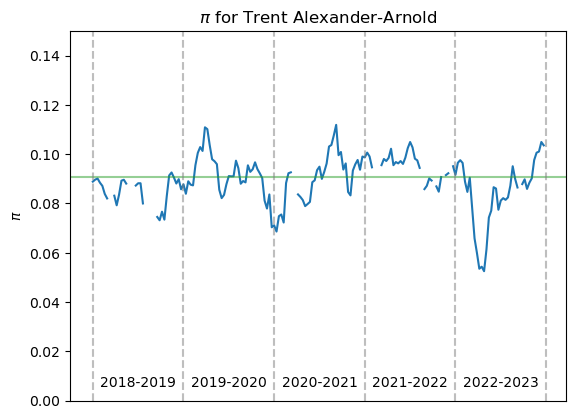

In [17]:
plt.plot(pi, color='tab:blue')

# Horizontal line with alpha
plt.axhline(1/11, linestyle='-', alpha=0.5, color="tab:green")

# Vertical dashed lines with alpha
for i in range(6):
    plt.axvline(i*38, color='tab:grey', linestyle='--', alpha=0.5)

# Time labels in the middle of each interval
intervals = ["2018-2019", "2019-2020", "2020-2021", "2021-2022", "2022-2023"]

for i, label in enumerate(intervals):
    mid = (i * 38 + (i + 1) * 38) / 2
    plt.text(mid, 0.01, label, ha='center', va='top')

# Axis formatting
plt.xticks([])
plt.title(r'$\pi$ for Trent Alexander-Arnold')
plt.ylabel(r'$\pi$')
plt.ylim(0, 0.150)
plt.show()


### Perform Estimation

Now, use the observed $(\pi_t)_{t}$ to obtain maximum likelihood estimates of $\pi^*, \theta$, and $\sigma_\pi$.  We utilize the [$\texttt{pymle}$ package](https://github.com/jkirkby3/pymle), with some modifications.  See $\texttt{scripts/estimation.py}$ for details.

The approximate likelihood used is the Kessler method.  The optimization problem for this MLE task is highly non-convex and prone to numerical error, so we use a Latin Hypercube design for multiple initializations of the standard L-BFGS-B optimizer.  One can set $\texttt{n}\_\texttt{samples}$ for the number of restarts, and $\texttt{seed}$ for reproducibility.  

In [18]:
player_df_estim = player_df[player_df['pi'].notna()]

mle_results = pi_mle(player_df_estim, n_samples=1000, seed = 1)

LHS trials:   0%|          | 0/1000 [00:00<?, ?it/s]/home/jimmy/miniconda3/envs/soccer_analytics/lib/python3.11/site-packages/pymle/fit/Minimizer.py:77: OptimizeWarning: Unknown solver options: xtol, verbose
  res = minimize(function,
LHS trials:   0%|          | 2/1000 [00:00<01:24, 11.84it/s]/home/jimmy/python_projects/soccer_valuation/scripts/estimation.py:85: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(H_inv.diagonal())
LHS trials: 100%|██████████| 1000/1000 [01:29<00:00, 11.19it/s]


pi MLE Results:
theta     = 3.209442  ± 0.527152
pi_star      = 0.089689    ± 0.005754
sigma     = 0.136383  ± 0.007451
stationary_var = 0.000236
sd (sqrt of var) = 0.015359
cor(1wk)  = 0.940146



These roughly match the values in the paper (*at the time, there was no seed setting, so we cannot get exact reproducibility.*)

# Example: Mohamed Salah of Liverpool

We repeat the analysis for Mohamed Salah.

In [19]:
# Example
team = 'Liverpool'
player_name = 'Mohamed Salah'

# Extract player data across seasons for the specified team and player
player_pis = []
player_dates = []
for folder in folders:
    if player_name in pi_df[team][folder].index:
        player_pis.extend(pi_df[team][folder].loc[player_name])  
        player_dates.extend(pi_df[team][folder].columns)
player_df = pd.DataFrame({'pi_raw': player_pis}, index=pd.to_datetime(player_dates))
player_df


# Convert to numpy array
pi_raw = np.array(player_df['pi_raw'])

pi = rolling_average(pi_raw)

player_df['pi'] = pi

# Add time since start
time_start = player_df.index.min()
player_df['t'] = (player_df.index - time_start).days / 365.25
player_df


,pi_raw,pi,t
2018-08-12,0.0912,0.0990,0.0000
2018-08-20,0.0933,0.0978,0.0219
2018-08-25,0.1193,0.1009,0.0356
2018-09-01,0.0800,0.0975,0.0548
2018-09-15,0.0842,0.0948,0.0931
...,...,...,...
2023-05-03,0.1314,0.1096,4.7228
2023-05-06,0.1544,0.1063,4.7310
2023-05-15,0.0986,0.1088,4.7556
2023-05-20,0.0867,0.1071,4.7693


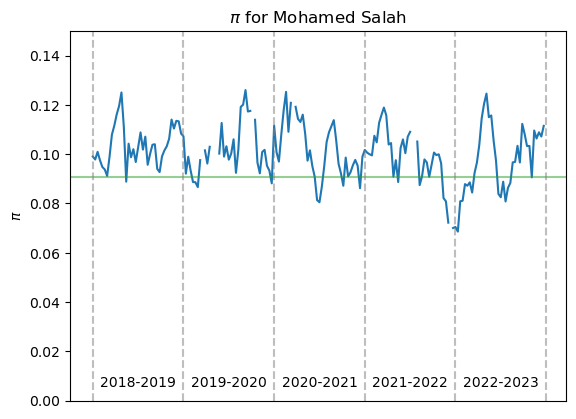

In [20]:
plt.plot(pi, color='tab:blue')

# Horizontal line with alpha
plt.axhline(1/11, linestyle='-', alpha=0.5, color="tab:green")

# Vertical dashed lines with alpha
for i in range(6):
    plt.axvline(i*38, color='tab:grey', linestyle='--', alpha=0.5)

# Time labels in the middle of each interval
intervals = ["2018-2019", "2019-2020", "2020-2021", "2021-2022", "2022-2023"]

for i, label in enumerate(intervals):
    mid = (i * 38 + (i + 1) * 38) / 2
    plt.text(mid, 0.01, label, ha='center', va='top')

# Axis formatting
plt.xticks([])
plt.title(r'$\pi$ for Mohamed Salah')
plt.ylabel(r'$\pi$')
plt.ylim(0, 0.150)
plt.show()


In [21]:
player_df_estim = player_df[player_df['pi'].notna()]

mle_results = pi_mle(player_df_estim, n_samples=1000, seed = 1)

LHS trials:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/jimmy/miniconda3/envs/soccer_analytics/lib/python3.11/site-packages/pymle/fit/Minimizer.py:77: OptimizeWarning: Unknown solver options: xtol, verbose
  res = minimize(function,
/home/jimmy/python_projects/soccer_valuation/scripts/estimation.py:85: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(H_inv.diagonal())
LHS trials: 100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


pi MLE Results:
theta     = 8.311415  ± 0.792874
pi_star      = 0.101414    ± 0.003960
sigma     = 0.205541  ± 0.010886
stationary_var = 0.000231
sd (sqrt of var) = 0.015199
cor(1wk)  = 0.852284

